# Getting Started with LangGraph

Objective of this notebook:  
- Understand what a **StateGraph** is.  
- Build a **toy graph** (without LLM) to see the mechanics clearly.  
- Then a **mini conversational agent** with a single LLM node.  
- Visualize the graph directly in the notebook.

## Key idea: workflow as a graph

In LangGraph:

- **State**: the shared state that flows through (data, messages, intermediate results).  
- **Nodes**: functions that read the state and return a state **update**.  
- **Edges**: transitions between nodes (linear or conditional).  
- **StateGraph**: the object that assembles everything and that we compile into an executable `graph`.

Conceptual schema:

```text
          +---------+       +---------+       +---------+
  START ->|  Node A | ----> |  Node B | ----> |  Node C |--> END
          +---------+       +---------+       +---------+
               
```

## 🔧 Installation (do once)

Uncomment if needed.

In [ ]:
# !pip install -U langgraph langchain-ollama python-dotenv
# For LM Studio (OpenAI-compatible API):
# !pip install -U langgraph langchain-openai python-dotenv
# For some visualizations (Mermaid PNG):
# !pip install -U grandalf

## 1️⃣ A first graph *without LLM*

We start with a very simple example:  
- the state is just an integer `value`,  
- we apply two nodes: `add_one` then `double`,  
- we see how the **StateGraph** works.

```text
initial value -> [add_one] -> [double] -> final value
```

In [14]:
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

class SimpleState(TypedDict):
    value: int

def add_one(state: SimpleState) -> SimpleState:
    print(f"[add_one] state in  = {state}")
    return {"value": state["value"] + 1}

def double(state: SimpleState) -> SimpleState:
    print(f"[double] state in  = {state}")
    return {"value": state["value"] * 2}

builder = StateGraph(SimpleState)
builder.add_node("add_one", add_one)
builder.add_node("double", double)

builder.add_edge(START, "add_one")
builder.add_edge("add_one", "double")
builder.add_edge("double", END)

simple_graph = builder.compile()



- Each node takes a `state` and returns a state **fragment**.  
- LangGraph takes care of **merging** the updates and circulating the state from node to node.

## 2️⃣ Visualize the graph

LangGraph provides a `get_graph()` method that allows generating:  
- **ASCII** of the graph,  
- **Mermaid** (text),  
- optionally PNG/SVG depending on installed libraries.

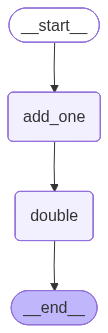

In [ ]:
g = simple_graph.get_graph()

# print("\nMermaid code:")
# print(g.draw_mermaid())

# print("ASCII graph:")
# print(g.draw_ascii())

# If grandalf is installed, we can also generate a PNG directly:
from IPython.display import Image
Image(g.draw_mermaid_png())

In [16]:
result = simple_graph.invoke({"value": 2})
print(f"[END] final state = {result}")

[add_one] state in  = {'value': 2}
[double] state in  = {'value': 3}
[END] final state = {'value': 6}


## 3️⃣ Mini conversational agent

We now move to a **message-based state**, closer to a real AI agent.

We will:  
- use `MessagesState` (pre-defined state in LangGraph),  
- create a single `assistant` node that calls an LLM via LangChain,  
- connect `START -> assistant -> END`.

This is the most minimal version of a LangGraph agent.

In [ ]:
import os
from dotenv import load_dotenv

from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import HumanMessage

# Load environment variables from .env file
load_dotenv()

# 1. Define the state
class ChatState(MessagesState):
    """State with a 'messages' key (list of messages)."""
    pass

# 2. Initialize the local model
llm_type = os.getenv("LOCAL_LLM_TYPE", "ollama")

if llm_type == "ollama":
    from langchain_ollama import ChatOllama
    
    ollama_base_url = os.getenv("OLLAMA_BASE_URL", "http://localhost:11434")
    ollama_model = os.getenv("OLLAMA_MODEL", "llama3.2:latest")
    
    chat_model = ChatOllama(
        model=ollama_model,
        base_url=ollama_base_url,
        temperature=0.2,
    )
    print(f"Using Ollama with model {ollama_model}")
    
elif llm_type == "lmstudio":
    from langchain_openai import ChatOpenAI
    
    lmstudio_base_url = os.getenv("LMSTUDIO_BASE_URL", "http://localhost:1234/v1")
    lmstudio_model = os.getenv("LMSTUDIO_MODEL", "local-model")
    
    chat_model = ChatOpenAI(
        model=lmstudio_model,
        base_url=lmstudio_base_url,
        api_key="not-needed",  # LM Studio doesn't require an API key
        temperature=0.2,
    )
    print(f"Using LM Studio with model {lmstudio_model}")
    
else:
    raise ValueError(f"Unrecognized LOCAL_LLM_TYPE: {llm_type}. Use 'ollama' or 'lmstudio'.")

# 3. Define the main node
def assistant_node(state: ChatState) -> ChatState:
    """
    Reads messages in the state, calls the LLM,
    returns an update with the new AI message.
    """

    # Here we call the LLM without adding a custom prompt, we could do it.
    response = chat_model.invoke(state["messages"])
    return {"messages": [response]}

# 4. Build the graph
builder = StateGraph(ChatState)
builder.add_node("assistant", assistant_node)
builder.add_edge(START, "assistant")
builder.add_edge("assistant", END)

chat_graph = builder.compile()
g = chat_graph.get_graph()
Image(g.draw_mermaid_png())

In [ ]:
# 5. Run a query
initial_state: ChatState = {
    "messages": [HumanMessage(content="Explain in 3 sentences what LangGraph is and how it complements LangChain.")]
}

result_state = chat_graph.invoke(initial_state)
for m in result_state["messages"]:
    print(f"{m.type.upper()}: {m.content}\n")

HUMAN: Explique en 3 phrases ce qu'est LangGraph et en quoi il complète LangChain.

AI: LangGraph est une bibliothèque qui permet de créer et de manipuler des graphes de connaissances en intégrant des modèles de langage. Elle complète LangChain en offrant une structure pour organiser et interroger des informations de manière plus complexe, facilitant ainsi la gestion des relations entre les données. Ensemble, LangGraph et LangChain permettent de construire des applications plus intelligentes et interactives en combinant la puissance des modèles de langage avec des graphes de connaissances.



## Conclusion: Role of this notebook 

- The LangChain notebook shows how to **build an individual agent / chain**.  
- This LangGraph notebook shows how to **orchestrate** steps as a graph.  
- The last notebook (weather + calendar) will then illustrate a **richer agent pattern** with multiple tools and real logic.
